In [198]:
%matplotlib inline
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.lines import Line2D
from matplotlib import style
import matplotlib.gridspec as gridspec
style.use(['dark_background', 'seaborn-dark-palette'])
import pandas as pd
from astropy.io import fits
from astropy.coordinates import SkyCoord
from astropy.coordinates import Angle
from astropy import units as u
from astropy.table import QTable
import tarfile
import sqlite3
import lsst.daf.persistence as dafPersist
from lsst.daf.base import DateTime
#import diaObjectAnalysis as doa
#import plotLightcurve as plc
#import apdbPlots as pla
import scipy
sys.path.append('/epyc/users/mrawls/premap2019/ap_pipe-notebooks/')
from apdbPlots import makeSrcTableFlags
import lsst.afw.display as afwDisplay
afwDisplay.setDefaultBackend('matplotlib')
from astropy.visualization import ZScaleInterval, SqrtStretch, ImageNormalize
import lsst.geom

In [199]:
hitsDataDir='/epyc/users/mrawls/premap2019/hits-dr1'
hitsFilename='HiTS_DR1_variables_DM-dataset-subset.fits'
hitsFilepath=os.path.join(hitsDataDir,hitsFilename) # Creates file path to the HiTS DR1 database
hitsTable=fits.open(hitsFilepath) # Load data as an astropy fits thing
hitsDf=pd.DataFrame(hitsTable[1].data) # Turn data into a pandas dataframe

In [200]:
hitsDfQSO_filter = hitsDf[hitsDf['QSO_Prob'] > 0.80]
hitsDfQSO = hitsDfQSO_filter.drop(['Variable_prob', 'Periodic_prob', 'DSCT_Prob', 'EB_Prob', 'Predicted_class',
                                   'ROTVAR_Prob', 'RRLYR_Prob', 'CV_Prob', 'SNe_Prob'], axis = 1)

In [201]:
repo = '/epyc/users/mrawls/hits2015/rerun/cw_2020_02'
butler = dafPersist.Butler(repo) # Butler function retrieves the data
dbName = 'association.db'
dbPath = os.path.join(repo, dbName) # Joins repo and dbName to form a path to the database
connection = sqlite3.connect(dbPath) # Opens a connection to the database

# Read data from the database to pandas dataframes
objTable = pd.read_sql_query('select diaObjectId, ra, decl, nDiaSources, \
                              gPSFluxMean, gPSFluxMeanErr, \
                              validityEnd, flags, \
                              gTOTFluxMean, gTOTFluxMeanErr \
                              from DiaObject where validityEnd is NULL;', connection) 
srcTableAll = pd.read_sql_query('select diaSourceId, diaObjectId, \
                                  ra, decl, ccdVisitId, \
                                  midPointTai, apFlux, psFlux, apFluxErr, \
                                  psFluxErr, totFlux, totFluxErr, flags \
                                  from DiaSource;', connection)

In [202]:
MILLI_all_filtered = pd.read_csv('/epyc/users/tw94/lsst-hits-bump/mrawls/MILLI_all_filtered.csv')
MILLI_all_filtered.head()

,ra,dec,ra_deg,dec_deg,bmag,rmag,redshift,radio_name,xray_name,lii,...,optical_flag,red_psf_flag,blue_psf_flag,ref_name,ref_redshift,qso_prob,class,idx,d2d_deg,diaObjectId
0,09 57 23.69,+01 14 58.7,149.348708,1.249639,19.73,19.44,2.484,,,237.26096,...,jG,-,-,DR14Q,DR14Q,,QSO TYPE 1,39116,0.234868,176486889161752879
1,10 03 05.70,+01 15 03.5,150.773750,1.250972,20.98,19.83,0.748,,,238.38186,...,pG,-,-,2QZ,2QZ,,QSO TYPE 1,18215,0.185993,176547031588798698
2,10 00 18.59,+01 15 06.1,150.077458,1.251694,21.36,19.95,0.861,,,237.82779,...,pG,-,-,2QZ,2QZ,,QSO TYPE 1,3314,0.137841,176547035883766087
3,09 56 47.47,+01 15 23.9,149.197792,1.256639,17.39,14.58,0.064,FIRST J095647.4+011523,,237.13686,...,p+G,1,1,PGC,DR16,100,AGN UNCLASSIFIED,39116,0.354526,176486889161752879
4,10 02 07.77,+01 15 27.2,150.532375,1.257556,21.19,20.37,2.517,,,238.18185,...,jG,1,-,DR14Q,DR14Q,,QSO TYPE 1,31159,0.000027,176486914931556904


## Plotting All the Things

In [203]:
def plotLSSTLightcurve(diaObjectId, dbPath='/epyc/users/mrawls/hits2015/rerun/cw_2020_02/association.db'):
    '''Plot a light curve for a DIA (Difference Image Analysis) Object
    from an LSST APDB (Alert Production database).
    
    Parameters
    ----------
    diaObjectId : Identifier for an LSST DIA object
    
    dbPath : Path on disk to an APDB we can load DIA Objects or DIA Sources from
        often the database is named `association.db`

    '''
        
    # Load all sources for this object only
    connection = sqlite3.connect(dbPath)
    forcedSrcTable = pd.read_sql_query(f'select diaObjectId, midPointTai, psFlux, psFluxErr, totFlux, totFluxErr \
                                       from DiaForcedSource where diaObjectId = {diaObjectId};', connection)
    srcTable = pd.read_sql_query(f'select diaObjectId, midPointTai, ccdVisitId, psFlux, psFluxErr, totFlux, totFluxErr \
                                 from DiaSource where diaObjectId = {diaObjectId};', connection)

    # Convert flux to magnitude
    #mags = (np.array(forcedSrcTable['totFlux'])*u.nJy).to(u.ABmag)
    #magErrs = 1.0857 / forcedSrcTable['totFluxErr'] / forcedSrcTable['totFlux']
    #forcedSrcTable['mags'] = mags
    #forcedSrcTable['magErrs'] = magErrs
    
    #mags = (np.array(srcTable['totFlux'])*u.nJy).to(u.ABmag)
    #magErrs = 1.0857 / srcTable['totFluxErr'] / srcTable['totFlux']
    #srcTable['mags'] = mags
    #srcTable['magErrs'] = magErrs
    
    plt.figure(figsize=(10,4))
    
  
  
    # Plot the LSST light curve (forced PSF photometry on calexp at DIASource position)
    plt.errorbar(srcTable['midPointTai'], srcTable['totFlux'], 
                 yerr=srcTable['totFluxErr'], ls=':', marker='o', label='LSST Source', color='C0')
    
    # Plot the LSST light curve (forced PSF photometry on calexp at DIAObject position)
    #plt.errorbar(forcedSrcTable['midPointTai'], forcedSrcTable['totFlux'], 
     #            yerr=forcedSrcTable['totFluxErr'], ls=':', marker='o', label='LSST', color='C0')
    
    # Plot the LSST light curve directly from source catalogs
    #if plotSourceCatLightCurve:
       # objTable = pd.read_sql_query('select diaObjectId, ra, decl, nDiaSources \
        #                      from DiaObject where validityEnd is NULL;', connection)
       # sourceCatTimes, sourceCatMags, sourceCatMagErrs = getSourceCatLightCurve(obj, objTable, srcTable, butler)
       # plt.errorbar(sourceCatTimes, sourceCatMags, yerr=sourceCatMagErrs, ls=':', marker='o', label='LSST SourceCat', color='C2')
    
    

    # Add some plot labels, and reverse the y-axis so bright stuff is at the top
    plt.xlabel('Time (MJD)')
    plt.ylabel('Instantaneous Flux (nJy)')
    #plt.legend(frameon=False, prop={'size': 16})

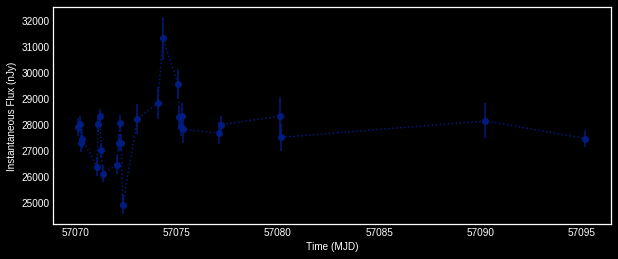

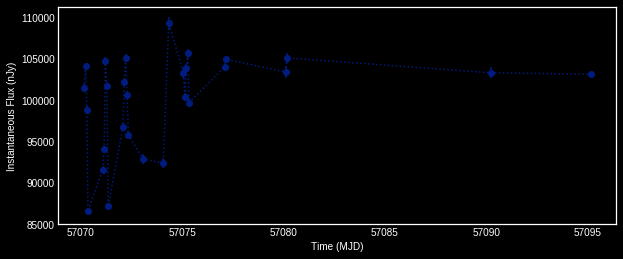

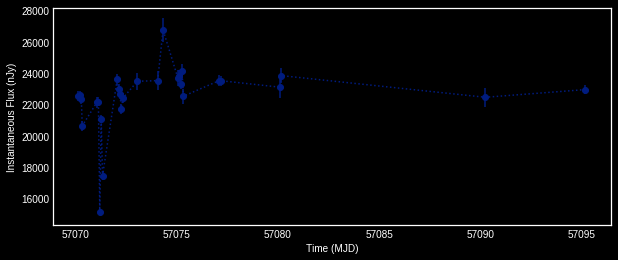

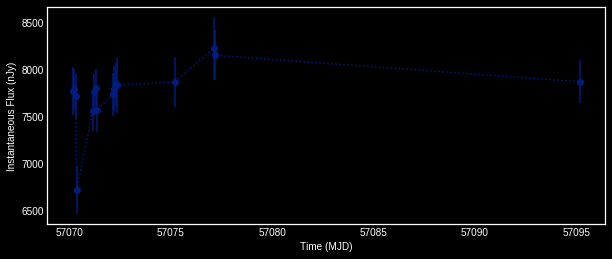

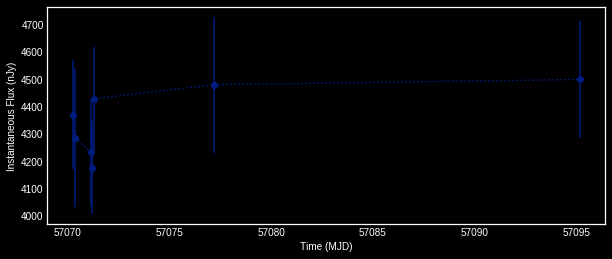

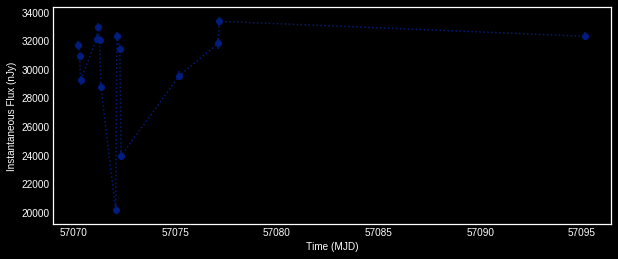

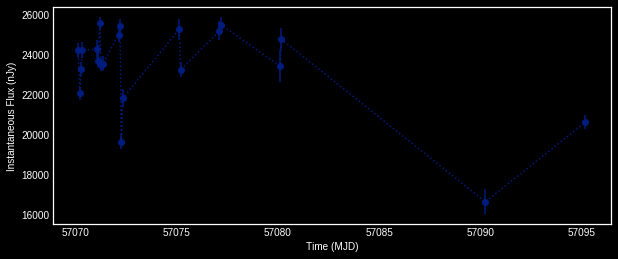

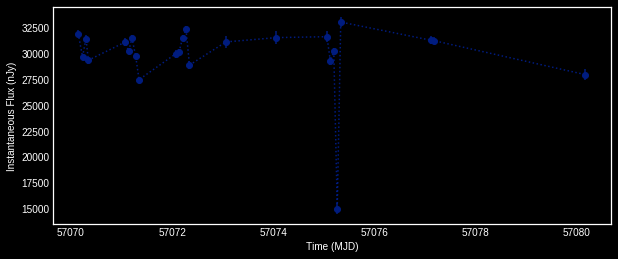

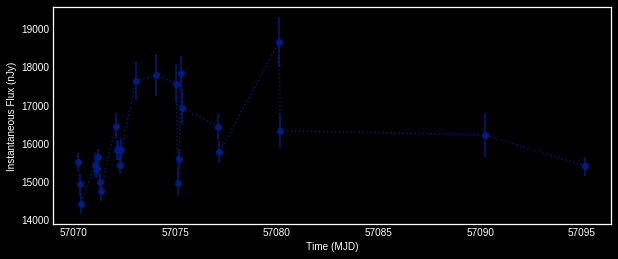

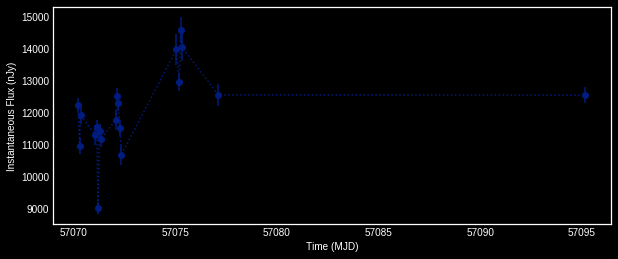

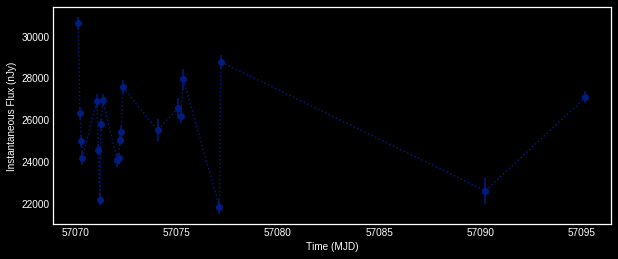

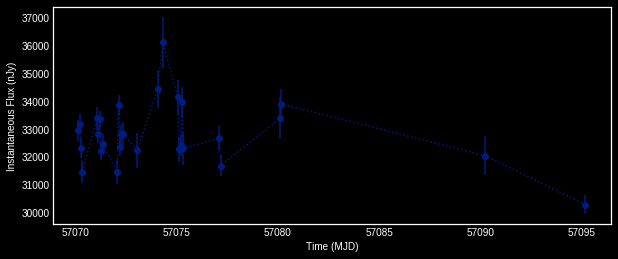

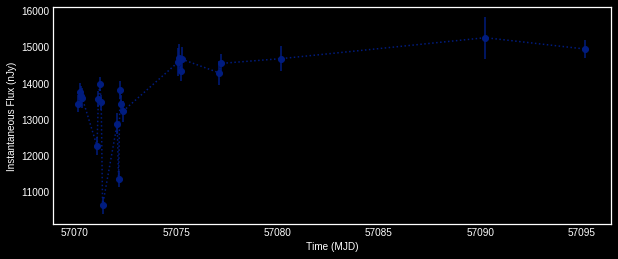

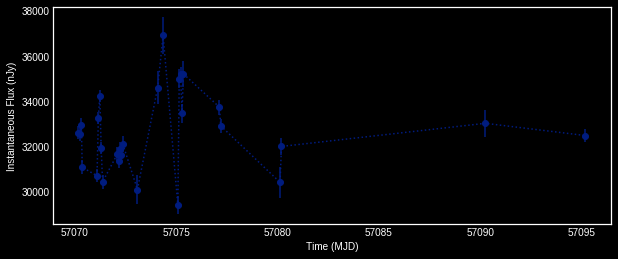

In [204]:
for obj in MILLI_all_filtered['diaObjectId'].loc[MILLI_all_filtered['d2d_deg'] < 0.00001]:
     plotLSSTLightcurve(obj)

#### Trying to make Meredith's cool plot

In [205]:
dataId = {'visit': 413696, 'ccd': 47}
calexp = butler.get('calexp', dataId = dataId)
src = butler.get('src', dataId = dataId)
psfRadius = calexp.getPsf().computeShape().getDeterminantRadius()

In [206]:
dataId={'visit':413696,'ccdnum':47 } # randomly chosen
processedImage=butler.get('calexp', dataId=dataId)

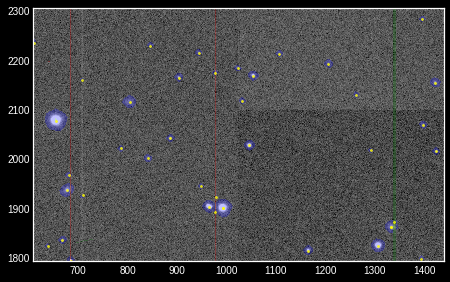

In [207]:
disp1 = afwDisplay.Display(1)
disp1.scale('asinh', 'zscale', Q=3)
disp1.mtv(calexp)
disp1.zoom(8)
plt.plot(src['slot_Centroid_x'], src['slot_Centroid_y'], marker = 'o', linestyle = 'none',
        mfc = 'none', ms = psfRadius, color = 'yellow')


#### Now some QSO's

In [208]:
diaObjectIdArray = MILLI_all_filtered['diaObjectId'].loc[MILLI_all_filtered['d2d_deg'] < 0.00001].values
len(diaObjectIdArray)

14

In [209]:
srcTableAll.head()

,diaSourceId,diaObjectId,ra,decl,ccdVisitId,midPointTai,apFlux,psFlux,apFluxErr,psFluxErr,totFlux,totFluxErr,flags
0,176486665823453487,176486665823453487,149.505905,3.015901,41091504,57070.141866,NaN,NaN,NaN,NaN,-568.214539,289.019452,25299404
1,176486665823453488,176486665823453488,149.506049,3.018367,41091504,57070.141866,-11508.174734,NaN,1092.173206,NaN,-35.963249,376.602222,25299404
2,176486665823453489,176486665823453489,149.511464,2.886295,41091504,57070.141866,-3267.821724,-2109.396629,990.776311,382.598305,165.012403,391.136272,25166152
3,176486665823453490,176486665823453490,149.511534,2.883162,41091504,57070.141866,-1756.352107,-2184.019930,984.997399,383.163993,167.639437,391.396218,25168328
4,176486665823453491,176486665823453491,149.512223,2.932614,41091504,57070.141866,-462.552054,-319.352917,781.301703,362.903789,29949.387116,366.863338,41943040


In [210]:
ccdVisitIds = []
ra = []
dec = []
for i in range(14):
    Q = srcTableAll['ccdVisitId'].loc[srcTableAll['diaObjectId'] == diaObjectIdArray[i]].values
    ccdVisitIds.append(Q[0])
for i in range(14):
    Q = srcTableAll['ra'].loc[srcTableAll['diaObjectId'] == diaObjectIdArray[i]].values
    ra.append(Q[0])
for i in range(14):
    Q = srcTableAll['decl'].loc[srcTableAll['diaObjectId'] == diaObjectIdArray[i]].values
    dec.append(Q[0])

In [211]:
table4plotzdict = {'ccdVisitId': ccdVisitIds, 'ra':ra, 'dec':dec, 'diaObjectId':diaObjectIdArray}
table4plotz = pd.DataFrame(data=table4plotzdict)

In [212]:
table4plotz['ccd'] = table4plotz.ccdVisitId.apply(lambda x: str(x)[-2:])
table4plotz['Visit'] = table4plotz.ccdVisitId.apply(lambda x: str(x)[:-2])

In [213]:
table4plotz

,ccdVisitId,ra,dec,diaObjectId,ccd,Visit
0,41091560,149.858874,1.263207,176486906341622217,60,410915
1,41091562,150.371598,1.287750,176486914931556787,62,410915
2,41091555,150.732886,1.625086,176486884866785513,55,410915
3,41091549,150.535605,1.764869,176486859096981880,49,410915
4,41097147,150.097791,1.845271,176510902323905000,47,410971
5,41097142,150.195584,2.004435,176510880849068731,42,410971
6,41091528,150.037197,2.244679,176486768902668491,28,410915
7,41091524,150.824649,2.398799,176486751722799410,24,410915
8,41097122,150.327394,2.460845,176510794949722736,22,410971
9,41097117,150.520941,2.625368,176510773474886173,17,410971


In [214]:
MILLI_close = MILLI_all_filtered.loc[MILLI_all_filtered['d2d_deg'] < 0.00001]

In [215]:
def snapshotplots(idx):
    dataId = {'visit': float(table4plotz['Visit'].iloc[idx]), 'ccd': float(table4plotz['ccd'].iloc[idx])}
    calexp = butler.get('calexp', dataId = dataId)
    centerSource = lsst.geom.SpherePoint(table4plotz['ra'].iloc[idx], table4plotz['dec'].iloc[idx], lsst.geom.degrees)
    size = lsst.geom.Extent2I(25, 25)
    calexpArray = calexp.getCutout(centerSource, size).getMaskedImage().getImage().getArray()
    norm = ImageNormalize(calexpArray, interval=ZScaleInterval(), stretch=SqrtStretch())
    plt.imshow(calexpArray, cmap='gray', norm=norm, origin='lower')

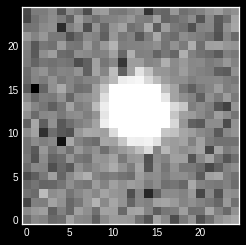

In [216]:
for i in range(len(MILLI_close)):
    snapshotplots(i) #Why won't this plot more than one?

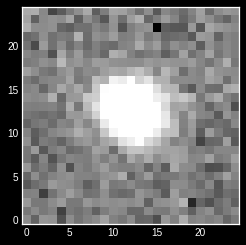

In [217]:
snapshotplots(0)

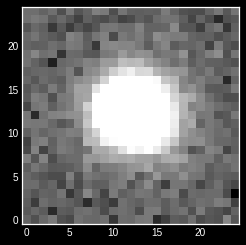

In [218]:
snapshotplots(1)

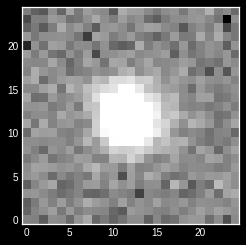

In [219]:
snapshotplots(2)

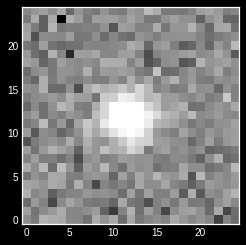

In [220]:
snapshotplots(3)

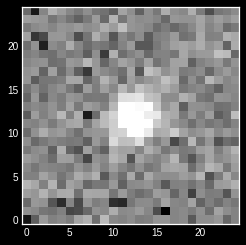

In [221]:
snapshotplots(4)

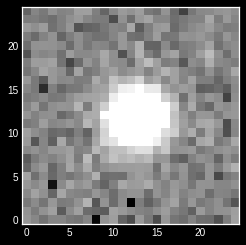

In [222]:
snapshotplots(5)

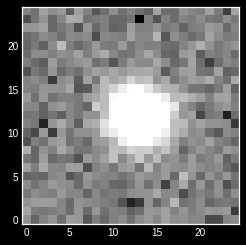

In [223]:
snapshotplots(6)

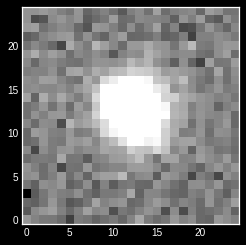

In [224]:
snapshotplots(7)

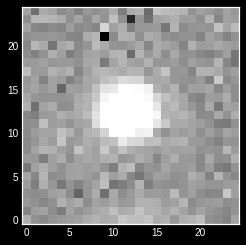

In [225]:
snapshotplots(8)

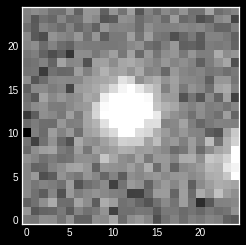

In [226]:
snapshotplots(9)

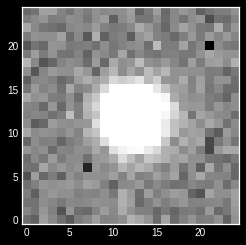

In [227]:
snapshotplots(10)

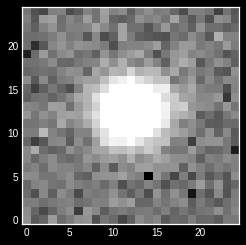

In [228]:
snapshotplots(11)

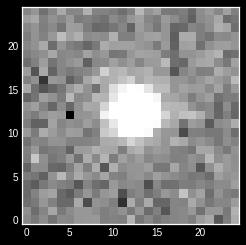

In [229]:
snapshotplots(12)

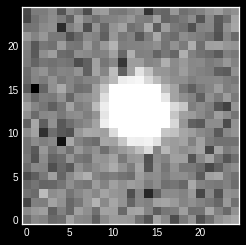

In [230]:
snapshotplots(13)

#### Testing out plotting the snapshot with its respective light curve.

In [301]:
def plotLSSTLightcurveAndSnapshot(idx, diaObjectId, dbPath='/epyc/users/mrawls/hits2015/rerun/cw_2020_02/association.db'):

        
    # Load all sources for this object only
    connection = sqlite3.connect(dbPath)
    forcedSrcTable = pd.read_sql_query(f'select diaObjectId, midPointTai, psFlux, psFluxErr, totFlux, totFluxErr \
                                       from DiaForcedSource where diaObjectId = {diaObjectId};', connection)
    srcTable = pd.read_sql_query(f'select diaObjectId, midPointTai, ccdVisitId, psFlux, psFluxErr, totFlux, totFluxErr \
                                 from DiaSource where diaObjectId = {diaObjectId};', connection)

    fig = plt.figure(figsize = (15,5))
    gs = plt.GridSpec(1, 2, width_ratios=[10, 5])
    ax1 = fig.add_subplot(gs[0])
    ax2 = fig.add_subplot(gs[1])
    
    
    if MILLI_close['xray_name'].iloc[idx] != '                      ':
        fig.suptitle(f'Xray Name: {MILLI_close["xray_name"].iloc[idx]}',x = .495 , y = 0.95, ha = 'center', fontsize = 14)
    elif MILLI_close['radio_name'].iloc[idx] != '                      ':
        fig.suptitle(f'Radio Name: {MILLI_close["radio_name"].iloc[idx]}',x = .495 , y = 0.95, ha = 'center', fontsize = 14)
    else:
        fig.suptitle(f'Xray/Radio Name: N/A',x = .495 , y = 0.95, ha = 'center', fontsize = 14)
  
    # Plot the LSST light curve (forced PSF photometry on calexp at DIASource position)
    ax1.errorbar(srcTable['midPointTai'], srcTable['totFlux'], 
                 yerr=srcTable['totFluxErr'], ls=':', marker='o', label='LSST Source', color='darkcyan')
    
    

    # Add some plot labels, and reverse the y-axis so bright stuff is at the top
    ax1.set_xlabel('Time (MJD)')
    ax1.set_ylabel('Instantaneous Flux (nJy)')
    #plt.legend(frameon=False, prop={'size': 16})
    
    #plot the snapshot image
    
    dataId = {'visit': float(table4plotz['Visit'].iloc[idx]), 'ccd': float(table4plotz['ccd'].iloc[idx])}
    calexp = butler.get('calexp', dataId = dataId)
    centerSource = lsst.geom.SpherePoint(table4plotz['ra'].iloc[idx], table4plotz['dec'].iloc[idx], lsst.geom.degrees)
    size = lsst.geom.Extent2I(25, 25)
    calexpArray = calexp.getCutout(centerSource, size).getMaskedImage().getImage().getArray()
    norm = ImageNormalize(calexpArray, interval=ZScaleInterval(), stretch=SqrtStretch())
    ax2.imshow(calexpArray, cmap='gray', norm=norm, origin='lower', aspect = 'auto')

In [295]:
MILLI_close['radio_name'].iloc[0]

'                      '

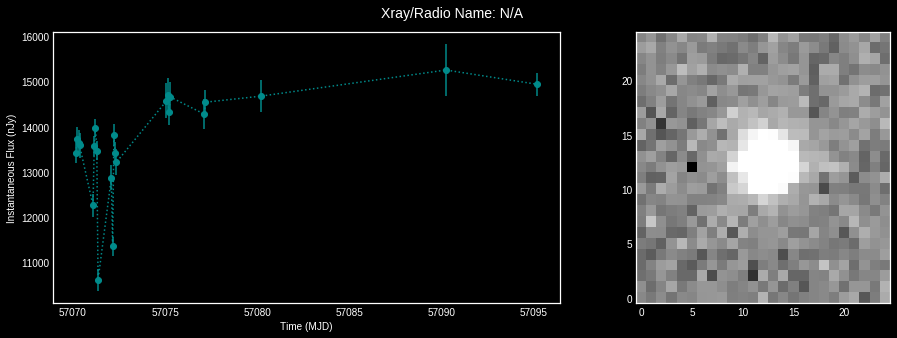

In [303]:
plotLSSTLightcurveAndSnapshot(12, table4plotz['diaObjectId'].iloc[12])

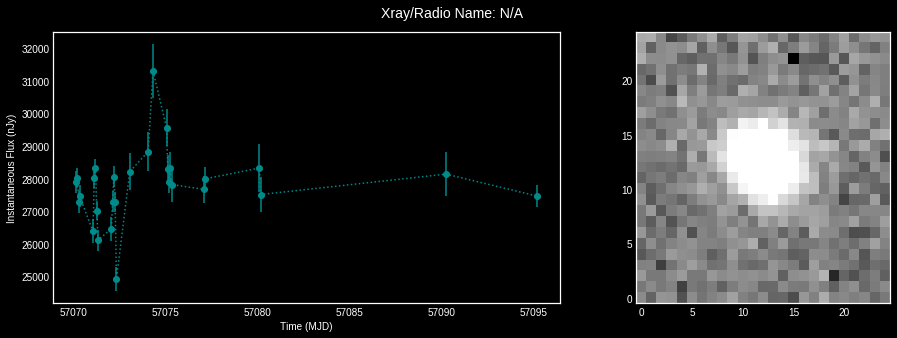

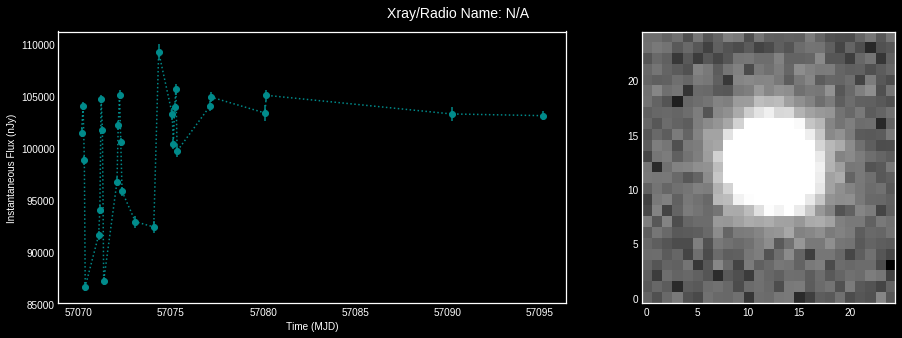

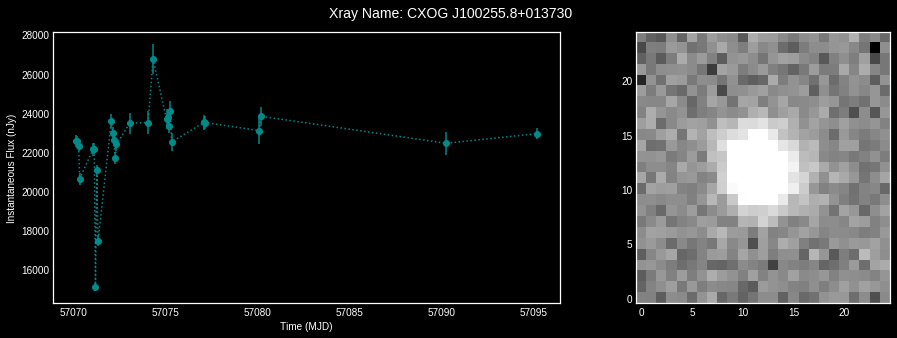

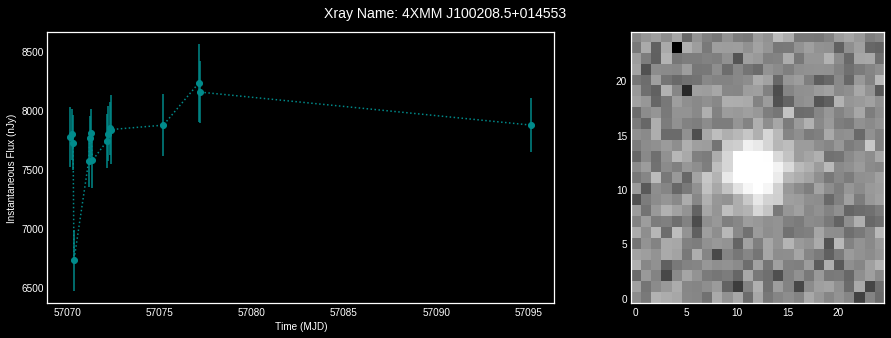

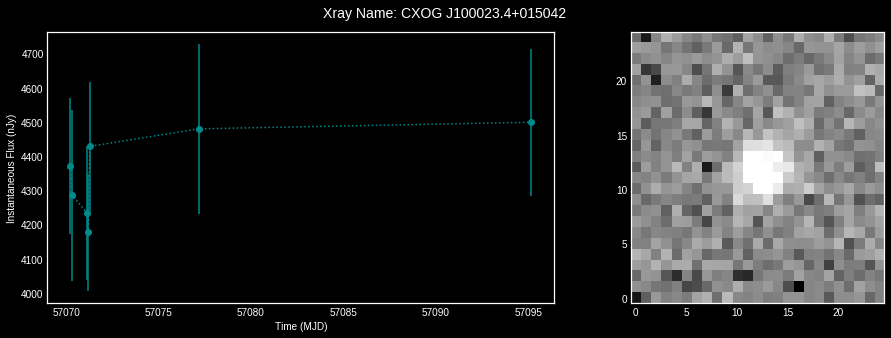

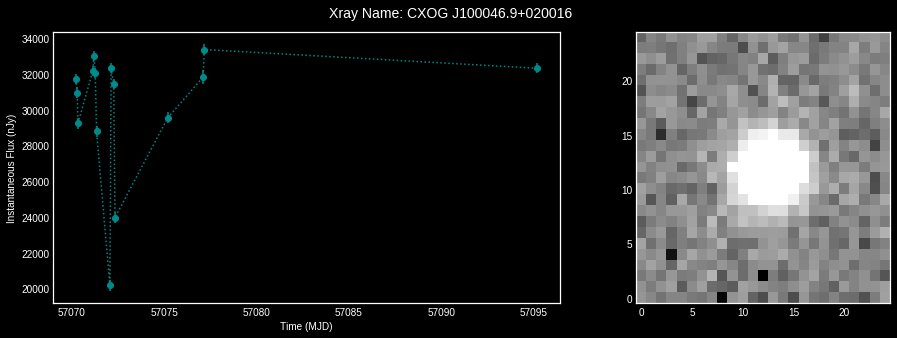

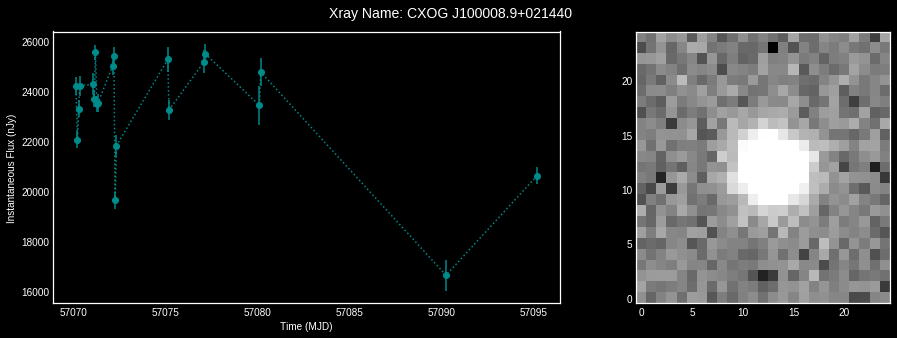

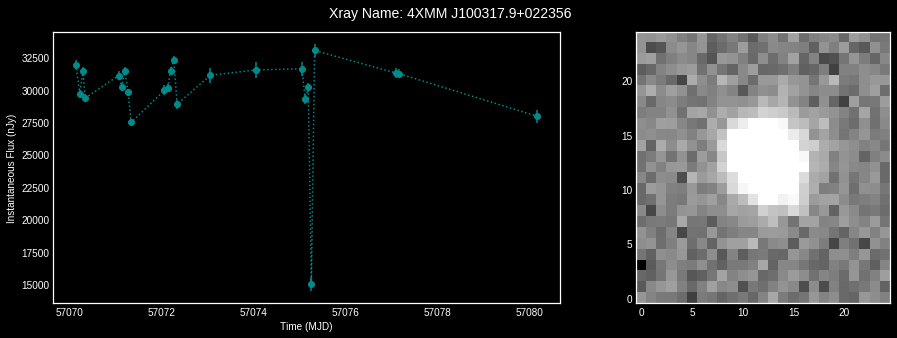

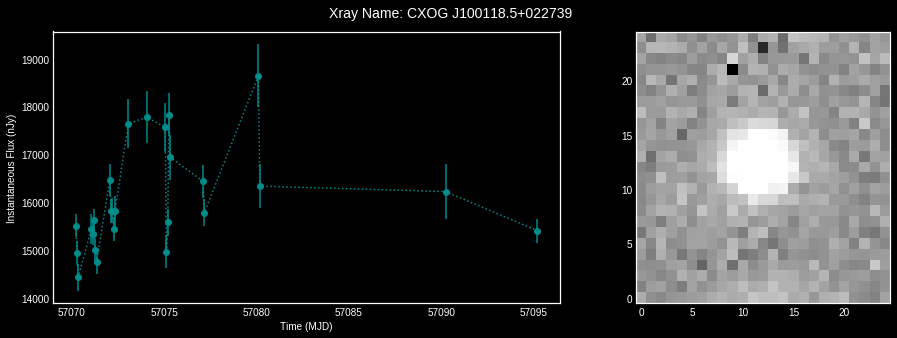

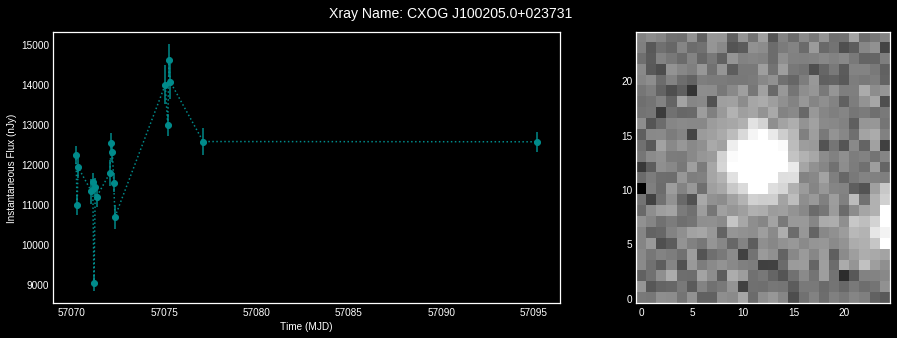

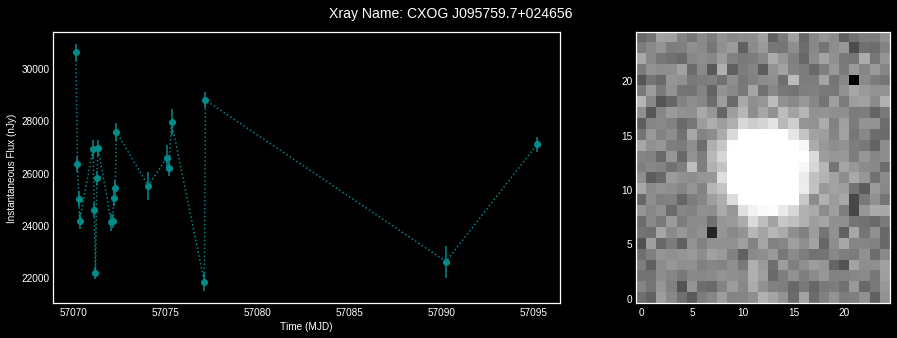

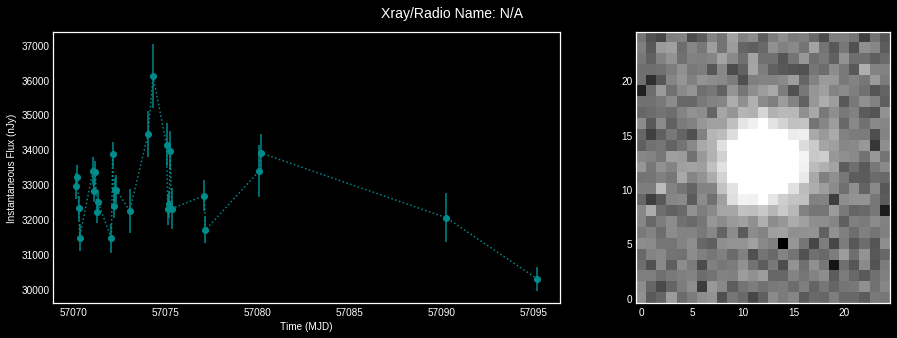

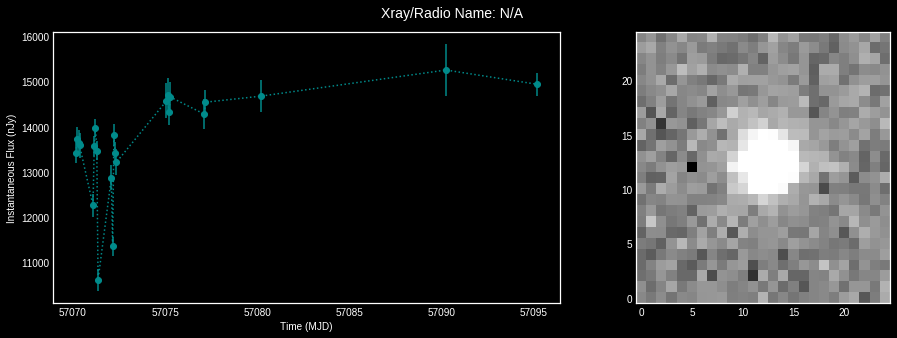

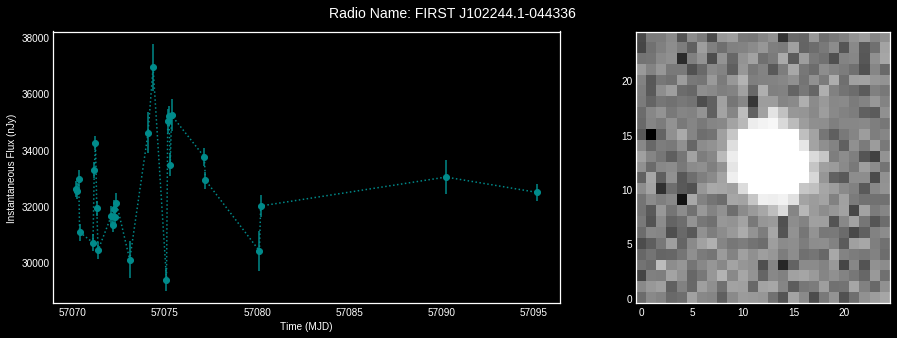

In [304]:
for i in range(14):
    plotLSSTLightcurveAndSnapshot(i, table4plotz['diaObjectId'].iloc[i])

In [234]:
MILLI_close

,ra,dec,ra_deg,dec_deg,bmag,rmag,redshift,radio_name,xray_name,lii,...,optical_flag,red_psf_flag,blue_psf_flag,ref_name,ref_redshift,qso_prob,class,idx,d2d_deg,diaObjectId
7,09 59 26.14,+01 15 47.5,149.858917,1.263194,20.96,19.97,1.406,,,237.64372,...,pG,1,1,2QZ,2QZ,,QSO TYPE 1,41435,0.000007,176486906341622217
12,10 01 29.19,+01 17 15.8,150.371625,1.287722,18.68,18.18,1.607,,,238.02145,...,pG,-,-,2QZ,DR14Q,,QSO TYPE 1,40969,0.000008,176486914931556787
124,10 02 55.89,+01 37 30.4,150.732875,1.625111,20.97,19.92,2.389,,CXOG J100255.8+013730,237.94255,...,pG,-,-,1885,1885,99,QSO TYPE 1,39091,0.000008,176486884866785513
196,10 02 08.55,+01 45 53.6,150.535625,1.764889,21.37,21.18,2.215,,4XMM J100208.5+014553,237.63305,...,g,-,-,1885,1885,100,QSO TYPE 1,41250,0.000004,176486859096981880
237,10 00 23.47,+01 50 42.8,150.097792,1.845222,21.81,20.76,,,CXOG J100023.4+015042,237.20007,...,j,-,-,MORX,,89,UNIDENTIFIED,39237,0.000005,176510902323905000
331,10 00 46.94,+02 00 15.9,150.195583,2.004417,20.60,20.13,1.918,,CXOG J100046.9+020016,237.10287,...,pG,-,-,2QZ,DR16,100,QSO TYPE 1,40572,0.000009,176510880849068731
486,10 00 08.92,+02 14 40.6,150.037167,2.244611,21.33,19.39,2.536,,CXOG J100008.9+021440,236.71563,...,p+G,-,-,1791,1791,97,QSO TYPE 1,40537,0.000004,176486768902668491
587,10 03 17.92,+02 23 55.6,150.824667,2.398778,21.09,20.51,2.300,,4XMM J100317.9+022356,237.16551,...,pG,-,-,XDQSO,MQ,99,QSO TYPE 1,35656,0.000006,176486751722799410
629,10 01 18.58,+02 27 39.1,150.327417,2.460861,20.53,20.07,1.052,,CXOG J100118.5+022739,236.70442,...,jG,1,-,1885,1885,100,QSO TYPE 1,39641,0.000009,176510794949722736
710,10 02 05.03,+02 37 31.5,150.520958,2.625417,20.67,19.17,0.519,,CXOG J100205.0+023731,236.67423,...,jmG,1,-,1886,1886,99,QSO TYPE 1,39769,0.000009,176510773474886173
